# Titanic Top 4% with Ensemble Modeling

+ 1 Introduction
+ 2 Load and check data
    - 2.1 Load data
    - 2.2 Outerlier detection
    - 2.3 joining train and test set
    - 2.4 check for null and missing values
+ 3 Feature analysis
    - 3.1 Numerical values
    - 3.2 Categorical valus
+ 4 Filling missing values
    - 4.1 Age
+ 5 Feature engineering
    - 5.1 Name / Title
    - 5.2 Family size
    - 5.3 Cabin
    - 5.4 Ticket
+ 5 Modeling
    - 6.1 Simple modeling
        * 6.1.1 Cross validate models
        * 6.1.2 Hyperparameter tunning for best models
        * 6.1.3 Plot learning curves
        * 6.1.4 Feature importance of the tree and based classifiers
    - 6.2 Ensemble modeling
        * 6.2.1 Combining models
    - 6.3 Prediction
        * 6.3.1 Predict and submit results

# 1 Introduction

In [1]:
pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 필요한 라이브러리 추가
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style = 'white', context = 'notebook', palette = 'deep')


In [3]:
from sklearn.model_selection import StratifiedKFold

# 2 Load and check data
## 2.1 Load data

In [4]:
train = pd.read_csv("C:/Python/00 Study/002_Titanic_Top 4% with ensemble modeling/titanic/train.csv")
test = pd.read_csv("C:/Python/00 Study/002_Titanic_Top 4% with ensemble modeling/titanic/test.csv")
IDtest = test["PassengerId"]
    # Train, test 셋 불러오기

## 2.2 Outlier detection
[이상치 탐지 관련 참고 1](https://hong-yp-ml-records.tistory.com/15).
[이상치 탐지 관련 참고 2](https://claryk.tistory.com/4). 

In [5]:
def detect_outliers(df, n, features):
    # (df, n, features) = (매개변수?)
    # df: dataframe
    #*** n: !?!?
    # features: columns
    outlier_indices = []
    # Tukey method (=IQR method): 1사분위보다 낮게 혹은 3사분위보다 높게 IQR의 1.5배를 벗어나는 포인트를 '외부_outside' 또는'거리가 먼_far out'으로 간주하여 이상치로 판단, 박스플롯 상 위스커를 벗어나는 범위에 검은 점으로 표시
    # 이상치는 극단적인 영향력을 지님 --> 분석 전, 이상치 탐색 과정 필요
    # 이상치 탐지 함수 detect_outliers; 각 열별 이상치 검정 --> 2개 이상의 열에서 이상치가 있는 관측값의 index를 outlier_indices에 담을 예정
    
    for col in features:
        Q1 = np.percentile(df[col], 25) # 1사분위수 (25번째 백분위)
        Q3 = np.percentile(df[col], 75) # 3사분위수 (75번째 백분위)

        IQR = Q3 - Q1
        # Interquartile range (IQR)
        # Q3 - Q1: 사분위수 상위 75% 지점 값 & 하위 25% 지점 값 차이
        
        outlier_step = 1.5 * IQR
        # 각 열별 Q1, Q3을 구하여 IQR의 1.5배 수치를 outlier_step에 저장
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        # 각 열별 이상치 기준점 이하/이상 관측값의 indext를 outlier_list_col에 저장
        
        outlier_indices.extend(outlier_list_col)
        # 각 열별로 구한 index를 extend 함수를 사용하여 취합
        
    outlier_indices = Counter(outlier_indices)
    # Counter 함수로 outlier_indices (이상치가 있는 관측값의 index) 내 인덱스 개수 확인
    
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    # outlier_indices에 저장된 키:값 연결
    
    return multiple_outliers
    
Outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])
# 4개 feature (Age, SibSp, Parch, Fare) 의 outlier 탐지

In [6]:
train.loc[Outliers_to_drop]
# outliers 행 전시
# 10 outliers (3 w. high ticket fare, 7 w. high SibSP)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [7]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)
# outliers 삭제

## 2.3 Joining train and test set

In [8]:
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)
# Train + test 데이터셋 조인 --> 동일한 수의 feature 획득 (categorical conversion) _feature engineering

## 2.4 Check for null and missing values

In [9]:
dataset = dataset.fillna(np.nan)
# 공란과 NaN 값을 NaN으로 입력

dataset.isnull().sum()
# Null 값 확인

# Age, Cabin w. important part of missing values
# Survived in test set replaced with NaN values since ther is no Survived column

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [10]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [13]:
train.describe()
# 데이터 요약 (요약 & 통계)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3 Feature analysis
## 3.1 Numerical values

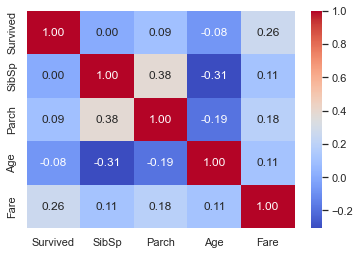

In [14]:
g = sns.heatmap(train[["Survived", "SibSp", "Parch", "Age", "Fare"]].corr(), annot = True, fmt = ".2f", cmap = "coolwarm")
# SibSp Parch Age Fare 값과 Survied 값의 상관관계 매트릭스

In [15]:
# Fare feature만 생존율과의 유의미한 상관관계를 보임
# 다른 feature들이 소용없다는 의미는 아님 --> 해당 feature들의 상세한 탐색 필요

### SibSP

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


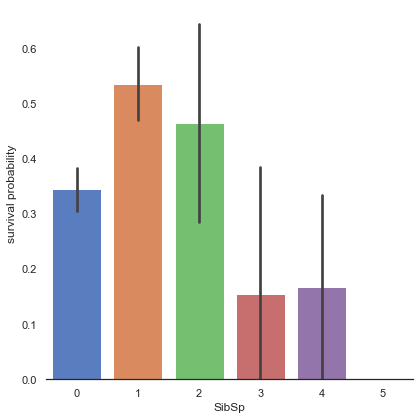

In [16]:
g = sns.factorplot(x = 'SibSp', y = 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
# SibSp - Survived 의 상관관계를 확인하기 위한 그래프 생성
g.despine(left = True)
# 축/테두리 정의; 기본값은 4개의 테두리 모두 존재, 위치 = True --> 테두리 제거
g = g.set_ylabels('survival probability')
# SibSp vs. Survived 탐색

In [17]:
# C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
#   warnings.warn(msg)
# C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
#   warnings.warn(msg, UserWarning)

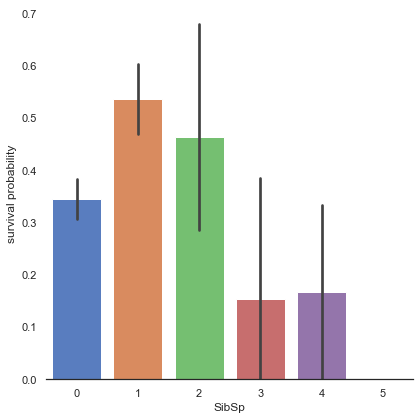

In [18]:
g = sns.catplot(x = 'SibSp', y = 'Survived', data = train, kind = 'bar', height = 6, palette = 'muted')
# SibSp - Survived 의 상관관계를 확인하기 위한 그래프 생성
g.despine(left = True)
# 축/테두리 정의; 기본값은 4개의 테두리 모두 존재, 위치 = True --> 테두리 제거
g = g.set_ylabels('survival probability')
# SibSp vs. Survived 탐색

# 위와 동일한 그래프, 경고 메시지 반영; facorplot --> catplot / size --> height 로 업데이트

In [19]:
# 많은 형제/자매 혹은 파트너가 있는 승객의 경우, 낮은 생존율
# 싱글인 승객 혹은 1/2명의 형제/자매가 있는 경우, 보다 높은 생존율

### Parch

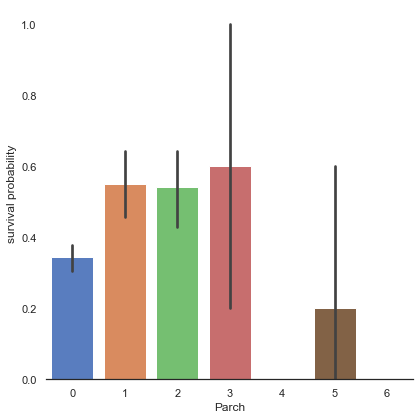

In [20]:
g = sns.catplot(x = 'Parch', y = 'Survived', data = train, kind = 'bar', height = 6, palette = 'muted')
# Parch와 생존율의 상관관계를 확인하기 위한 그래프 생성
g.despine(left = True)
g = g.set_ylabels('survival probability')

In [21]:
# 가족단위가 작을수록 높은 생존율 (> 싱글, > 3-4명, > 5-6명)
# 3명 가족에서의 표준편차 주의

### Age

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


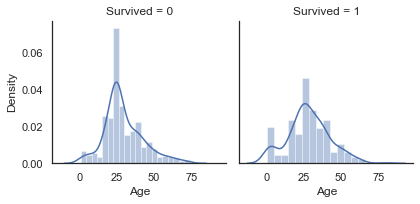

In [110]:
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')
# Age와 생존율

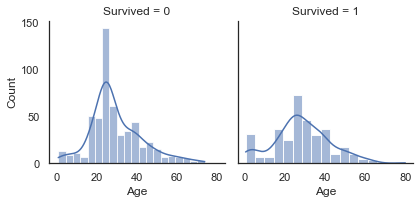

In [111]:
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.histplot, 'Age', kde = True)

In [23]:
# C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
#   warnings.warn(msg, FutureWarning)
# C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
#   warnings.warn(msg, FutureWarning)
# 추후 distplot은 버전에서 제거될 예정 --> displot 혹은 histplot 사용 필요

In [24]:
# Age 분포는 오른쪽 꼬리가 긴 모양 (가우시안 분포 maybe)
# 생존/미생존에서의 Age 분포는 상이한 것으로 나타남
# 어린 사람, 높은 생존율
# 60-80대, 낮은 생존율
# Age와 생존율 간 상관관계는 없어도, 특정 Age 그룹에서 더 낮거나 높은 생존율 확인

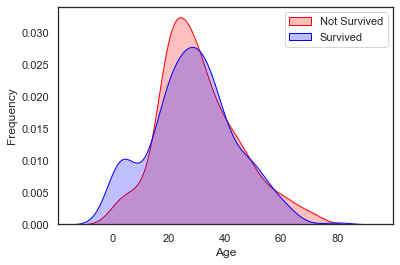

In [25]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color = 'Blue', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [26]:
# 아기와 유아에서 peak 발견

### Fare

In [27]:
dataset['Fare'].isnull().sum()
# 공란인 값의 개수 출력 (아래 명령 출력 이후 다시 실행하였기 때문에 하기엔 0으로 표시)

1

In [28]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
# 공란인 값에 중앙값 입력

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


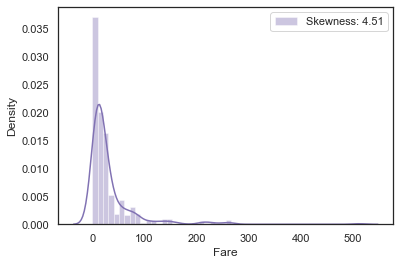

In [29]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')
# 위 distplot 생성 시와 동일한 경고 메시지
# 원본과 선그래프 상이한 것 버전 차이일 것으로 예상
# g.legend(loc = 'best') 범례를 자동으로 계산, 최적의 위치에 배치

In [30]:
# Fare 분포의 높은 왜도 확인됨
# 왜도 조정을 위해 log 함수를 적용하여 변환 진행

In [31]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


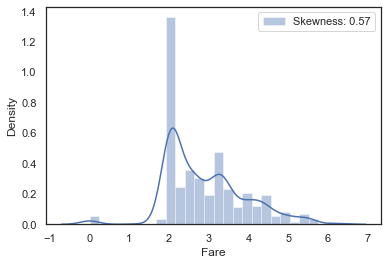

In [32]:
g = sns.distplot(dataset['Fare'], color = 'b', label = 'Skewness: %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')
# 위 distplot 생성 시와 동일한 경고 메시지
# g.legend(loc = 'best') 범례를 자동으로 계산, 최적의 위치에 배치

In [33]:
# log 함수 적용하여 진행한 변환으로 왜도 감소

## 3.2 Categorical values
### Sex

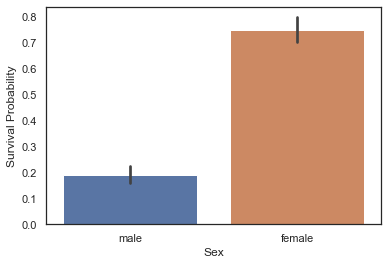

In [34]:
g = sns.barplot(x = 'Sex', y = 'Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [35]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


In [36]:
# 남자, 낮은 생존율
# Sex는 생존율 예측에 중요한 역할

### Pclass

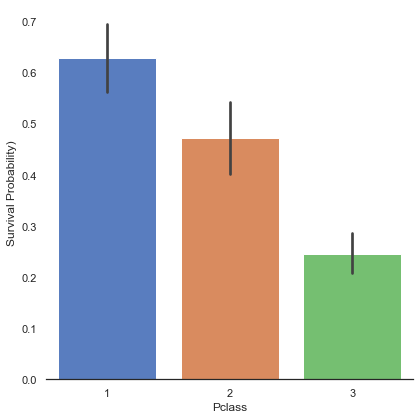

In [37]:
g = sns.catplot(x = 'Pclass', y = 'Survived', data = train, kind = 'bar', height = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability)')
# Pclass와 생존율의 상관관계 확인을 위한 바그래프 생성

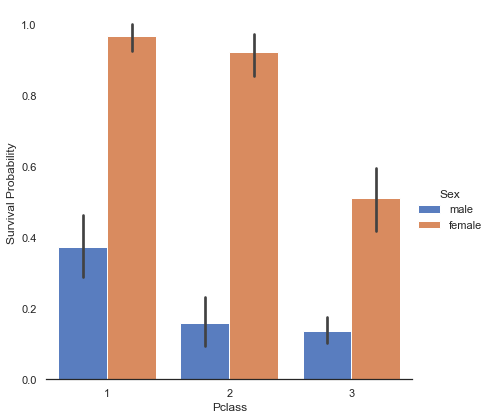

In [38]:
g = sns.catplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, height = 6, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival Probability')
# Pclass와 Sex에 따른 생존율 확인을 위한 바그래프 생성

In [39]:
# 각 클래스에서 상이한 생존율 확인
# 1 > 2 > 3 순으로 생존율 낮아짐

### Embarked

In [40]:
dataset['Embarked'].isnull().sum()
# Embarked 데이터셋 상 null 값의 개수

2

In [41]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Embarked 데이터셋의 null 값을 최빈값으로 대체하여 입력

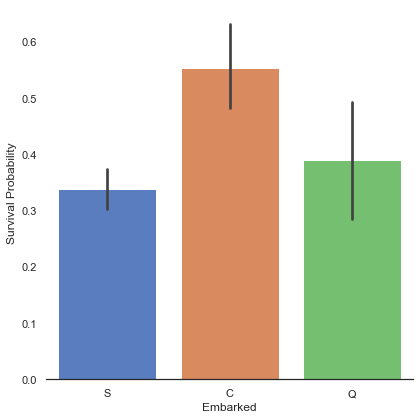

In [42]:
g = sns.catplot(x = 'Embarked', y = 'Survived', data = train, height = 6, kind = 'bar', palette = 'muted')
# Embarked와 생존율의 상관관계 확인을 위한 바그래프 생성
g.despine(left = True)
g = g.set_ylabels('Survival Probability')

In [43]:
# Cerbrurg (C) 항구 탑승객, 높은 생존율
# 필자 가설: Q, S 항구와 비교하여 C 항구로부터 탑승한 1 클래스 탑승객이 많았을 것

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


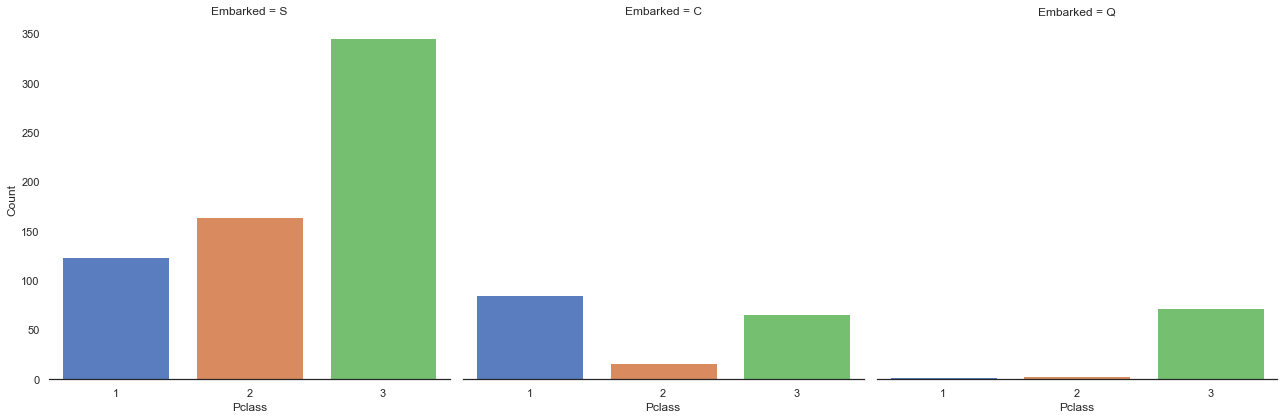

In [44]:
g = sns.catplot('Pclass', col = 'Embarked', data = train, height = 6, kind = 'count', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Count')

In [45]:
# Q, S 항구에서 3 클래스 탑승객 다수 / C 항구에서는 대부분이 1 클래스 탑승객

# 4 Filling missing values
## 4.1 Age

In [46]:
# Age 칼럼은 256개의 누락된 값 확인되나, 일부 그룹에서 유의미한 생존율 지표가 발견되었기 때문에 Age feature를 유지하고 누락 값을 대체하여 입력하는 것으로 결정
# Age와 가장 관련이 깊은 feature 확인 필요

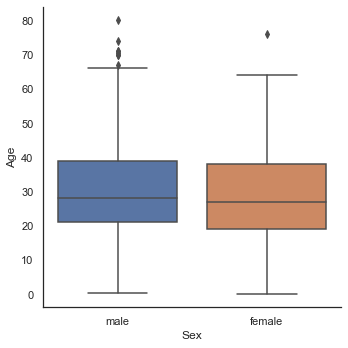

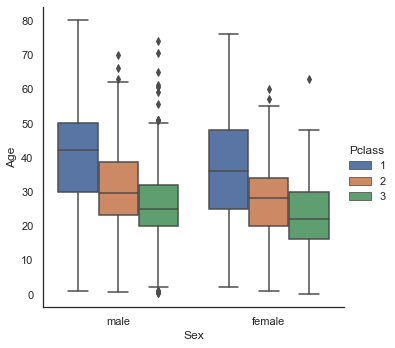

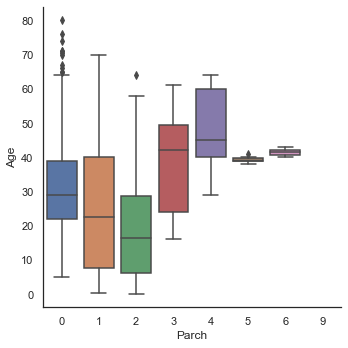

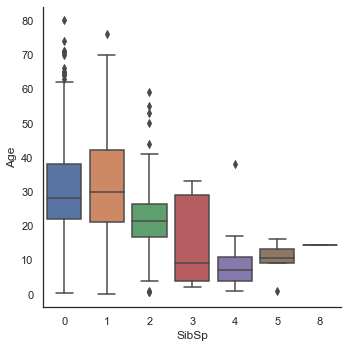

In [47]:
g = sns.catplot(y = 'Age', x = 'Sex', data = dataset, kind = 'box')
g = sns.catplot(y = 'Age', x = 'Sex', hue = 'Pclass', data = dataset, kind = 'box')
g = sns.catplot(y = 'Age', x = 'Parch', data = dataset, kind = 'box')
g = sns.catplot(y = 'Age', x = 'SibSp', data = dataset, kind = 'box')

In [48]:
# 남/여 동일한 Age 분포 확인 --> Age를 예측하기에 Sex는 좋은 지표가 될 수 없음
# Pclass의 경우, 1 > 2 > 3 순으로 나이가 적어짐
# 부모/아이가 많은 경우, 승객은 나이가 많아지고 형재자매/파트너가 있는 경우, 승객은 어려짐

In [49]:
dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})
# 명목척도 설정

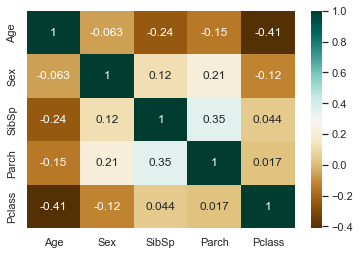

In [50]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap = 'BrBG', annot = True)

In [51]:
# Age - Sex; not correlated
# Age - Pclass, Parch, SibSp; negatively correlated
# Age - Parch; Age is growing w. the # of parents/children but the corrleation is (-)
# SibSp, Parch, Pclass 사용해서 Age의 누락값 대체 입력
# 비슷한 Pclass, Parch, SibSp 값을 가진 Age의 중앙값 사용

In [52]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)
# Age의 빈값

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

C:\Users\jiina\AppData\Local\Temp\ipykernel_992\4252635927.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
C:\Users\jiina\AppData\Local\Temp\ipykernel_992\4252635927.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_med


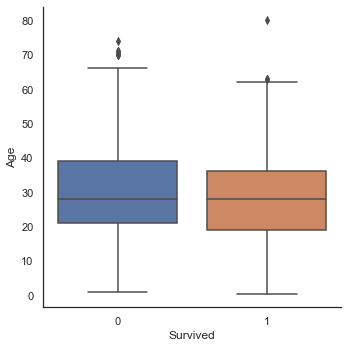

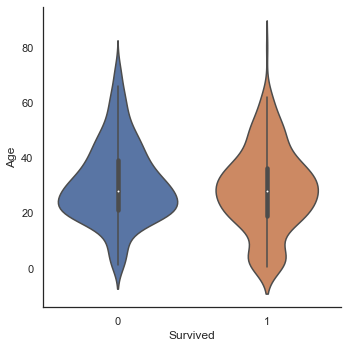

In [53]:
g = sns.catplot(x = 'Survived', y = 'Age', data = train, kind = 'box')
g = sns.catplot(x = 'Survived', y = 'Age', data = train, kind = 'violin')

In [54]:
# 생존/미생존 간 중앙값 일치
# 바이올린플롯 상, 어린 승객의 매우 높은 생존율 관찰됨

# 5 Feature engineering
## 5.1 Name/Title

In [55]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [56]:
# 이름 상 승객의 타이틀 정보 포함

In [57]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()
# 이름 앞에 존재하는 타이틀을 , 기준으로 나누고 .는 삭제

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

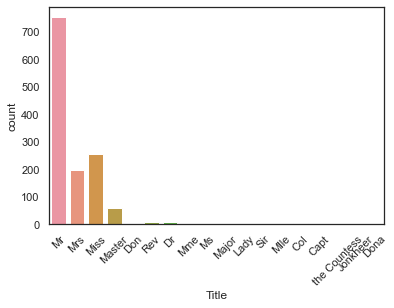

In [58]:
g = sns.countplot(x = 'Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)
# countplot; 범주형 변수의 빈도수 시각화
# plt.setp; x축의 라벨 회전

In [59]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master': 0, 'Miss': 1, 'Ms': 1, 'Mme':1, 'Mlle':1, 'Mrs': 1, 'Mr': 2, 'Rare': 3})
dataset['Title'] = dataset['Title'].astype(int)
# 명목척도 설정

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


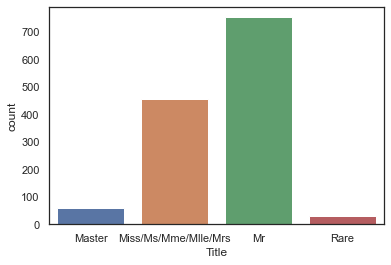

In [60]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

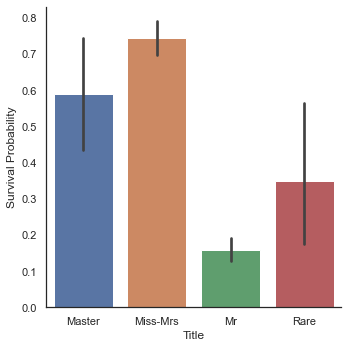

In [61]:
g = sns.catplot(x = 'Title', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival Probability')

In [63]:
dataset.drop(labels = ['Name'], axis = 1, inplace = True)
# 이름 feature 제외

## 5.2 Family size

In [64]:
# Fize as family size = sum(SibSp, Parch & 1)

In [65]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


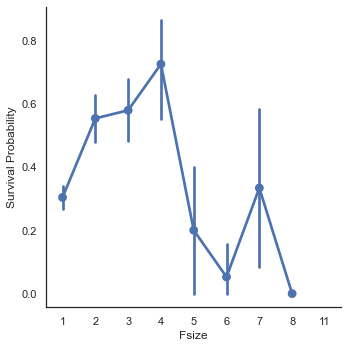

In [66]:
g = sns.factorplot(x = 'Fsize', y = 'Survived', data = dataset)
g = g.set_ylabels('Survival Probability')

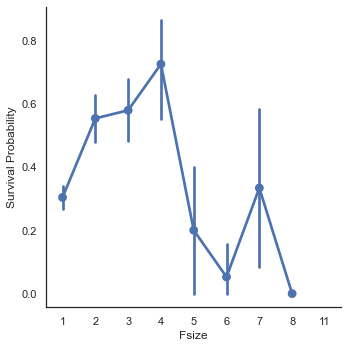

In [67]:
g = sns.catplot(x = 'Fsize', y = 'Survived', data = dataset, kind = 'point')
g = g.set_ylabels('Survival Probability')
# 위와 동일한 그래프, 경고 메시지 반영하여 추후 변경될 함수 이름으로 변경

In [68]:
# 가족 크기도 생존율에 중요한 기여
# 큰 가족, 최악의 생존율
# 가족의 4가지 분류 생성

In [69]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

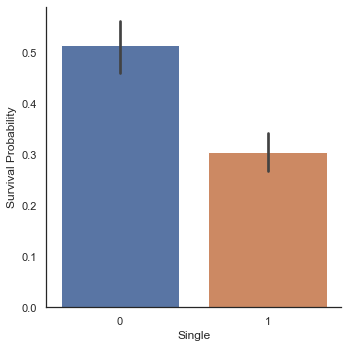

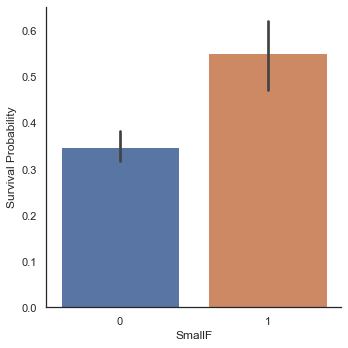

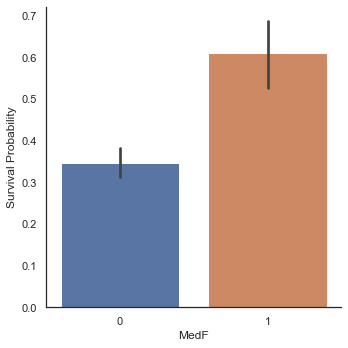

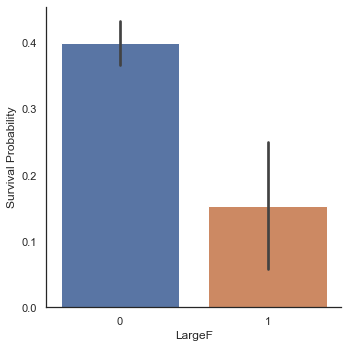

In [70]:
g = sns.catplot(x = 'Single', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x = 'SmallF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x = 'MedF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.catplot(x = 'LargeF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')

In [71]:
# Small & Medium Family, Single & Large Family 보다 높은 생존율

In [72]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em')
# Convert to indicator values Title & Embarked

In [73]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## 5.3 Cabin

In [74]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [75]:
dataset['Cabin'].describe()
#***왜 top이 다른 정보입니까

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [76]:
dataset['Cabin'].isnull().sum()

1007

In [77]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [78]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])
# Cabin 수를 Cabin 종류로 대체, 수가 없을 경우 X로 표시

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


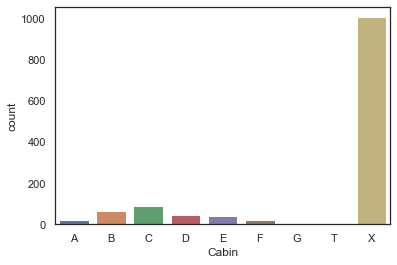

In [79]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

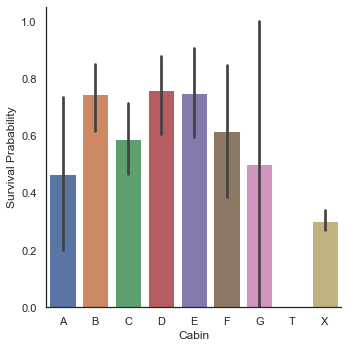

In [80]:
g = sns.catplot(y = 'Survived', x = 'Cabin', data = dataset, kind = 'bar', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Prabability')

In [81]:
# Cabin을 보유한 승객의 수가 적어, 표준 편차가 크게 존재하고 각 데스크의 승객 생존율은 파악 불가
# Cabin을 보유한 승객 생존율 (특히 B, C, D, E, F) > Cabin 미보유 승객 생존율

In [82]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

## 5.4 Ticket

In [83]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [84]:
# Ticket 상 prefix가 동일 --> 동일한 Cabin에 배정되었다는 뜻일 수 있음 --> 여객선 상에 실제 Cabin 위치 유추 가능
# Ticket 상 동일한 prefix 확인된 경우, 비슷한 Pclass 혹은 생존율 가능성
# Ticket feature을 ticket prefix로 대체하여 확인

In [85]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0])
    else:
        Ticket.append('X')
        
dataset['Ticket'] = Ticket
dataset['Ticket'].head()
# Ticket의 prefix 추출, prefix 미존재 시 X 표시

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [86]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')

In [87]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')
# Pclass 상 분류값 생성

In [88]:
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)
# 불필요한 변수 제거

In [89]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6 Modeling

In [90]:
# Train과 Test 데이터셋 나누기
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis = 1, inplace = True)

C:\Users\jiina\AppData\Local\Temp\ipykernel_992\550262580.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels = ['Survived'], axis = 1, inplace = True)


In [91]:
# Train feature와 label 나누기
train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels = ['Survived'], axis = 1)

C:\Users\jiina\AppData\Local\Temp\ipykernel_992\1079856235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Survived'] = train['Survived'].astype(int)


## 6.1 Simple modeling

### 6.1.1 Cross validate models


In [92]:
# 10 popular classifiers compared
# Each mean accuracy evaluated by a stratified kfold cross validation procedure

+ SVC
+ Decision Tree
+ AdaBoost
+ Random Forest
+ Extra Trees
+ Gradient Boosting
+ Multiple Layer Perception (Neural Network)
+ KNN
+ Logistic Regression
+ Linear Discriminant Analysis

In [93]:
# Cross validation model with kfold stratified cross val
kfold = StratifiedKFold(n_splits = 10)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


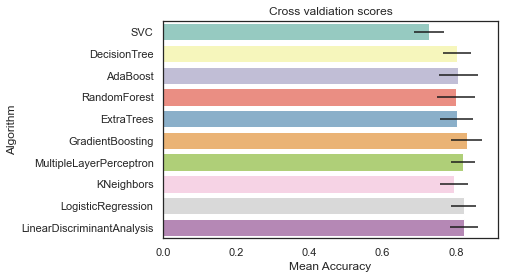

In [94]:
# 모델링 단계: 알고리즘 테스트
random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv = kfold, n_jobs = 4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 'Algorithm': ['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighbors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

g = sns.barplot('CrossValMeans', 'Algorithm', data = cv_res, palette = 'Set3', orient = 'h', **{'xerr': cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross valdiation scores')

In [95]:
# SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting classifiers chosen for the ensemble modeling

### 6.1.2 Hyperparameter tunning for best models

In [96]:
# A grid search optimization performed for AdaBoost, ExtraTrees, RandomForest, GradientBoosting and SVC classifiers
# 'n_jobs' parameter set to 4 (since there are 4 CPU)

In [97]:
# AdaBoost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state = 7)

ada_param_grid = {'base_estimator__criterion': ['gini', 'entropy'], 
                 'base_estimator__splitter': ['best', 'random'],
                 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1, 2], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [98]:
gsadaDTC.best_score_

0.8275536261491316

In [99]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

# Search grid for optimal parameters
ex_param_grid = {'max_depth': [None],
                 'max_features': [1, 3, 10],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [False],
                 'n_estimators': [100, 300],
                 'criterion': ['gini']}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

#Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320224719101124

In [100]:
# RFC parameters tunning
RFC = RandomForestClassifier()

# Search grid for optimal parameters
rf_param_grid = {'max_depth': [None],
                'max_features': [1, 3, 10],
                'min_samples_split': [2, 3, 10],
                'min_samples_leaf': [1, 3, 10],
                'bootstrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320097037793666

In [101]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['deviance'],
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.1, 0.05, 0.01],
                'max_depth': [4, 8],
                'min_samples_leaf': [100, 150],
                'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)
gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8320224719101124

In [102]:
# SVC classfier
SVMC = SVC(probability = True)
svc_param_grid = {'kernel': ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

### 6.1.3 Plot learning curves

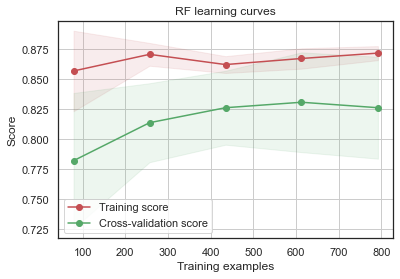

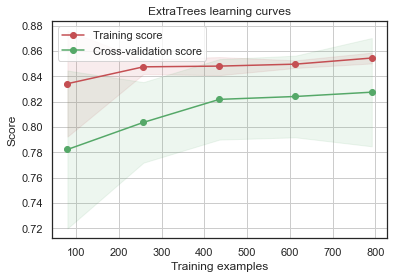

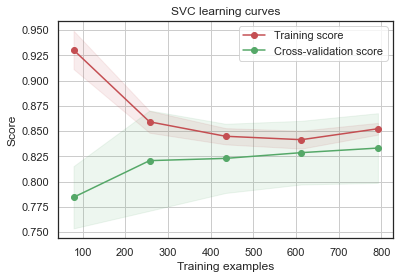

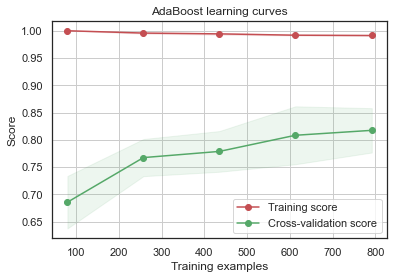

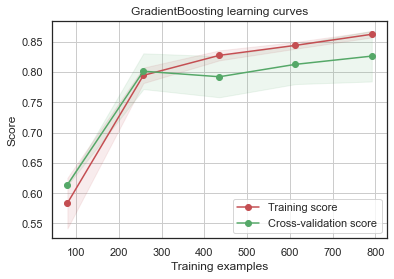

In [103]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Cross-validation score')
    
    plt.legend(loc = 'best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_, 'RF learning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsExtC.best_estimator_, 'ExtraTrees learning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, 'AdaBoost learning curves', X_train, Y_train, cv = kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', X_train, Y_train, cv = kfold)

### 6.1.4 Feature importance of tree based classifiers

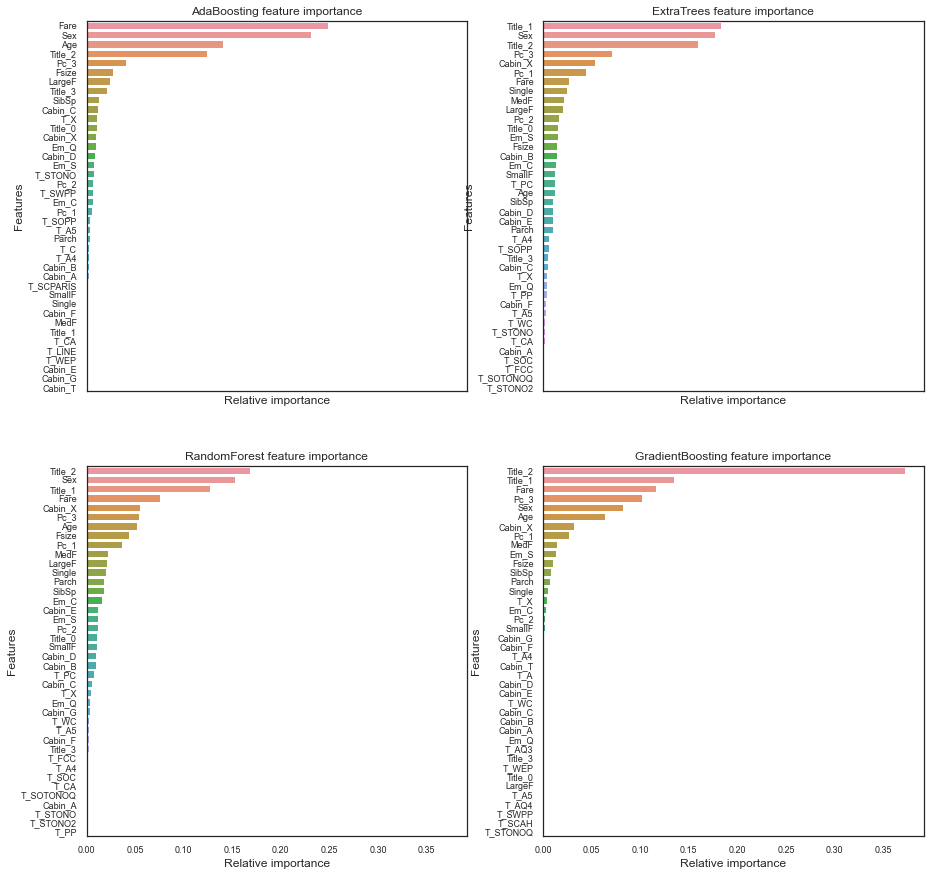

In [104]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = 'all', figsize = (15, 15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y = X_train.columns[indices][:40], x = classifier.feature_importances_[indices][:40], orient = 'h', ax = axes[row][col])
        g.set_xlabel('Relative importance', fontsize = 12)
        g.set_ylabel('Features', fontsize = 12)
        g.tick_params(labelsize = 9)
        g.set_title(name + ' feature importance')
        nclassifier += 1

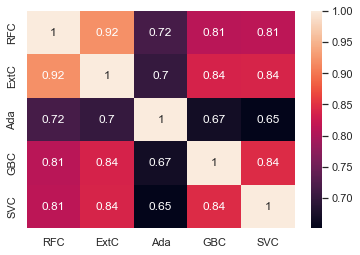

In [105]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name = 'RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name = 'ExtC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name = 'SVC')
test_Survived_AdaC = pd.Series(ada_best.predict(test), name = 'Ada')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name = 'GBC')

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC], axis = 1)

g = sns.heatmap(ensemble_results.corr(), annot = True)

## 6.2 Ensemble modeling
### 6.2.1 Combining models

In [106]:
votingC = VotingClassifier(estimators = [('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting = 'soft', n_jobs = 4)

votingC = votingC.fit(X_train, Y_train)

## 6.3 Prediction
### 6.3.1 Predict and submit results

In [107]:
test_Survived = pd.Series(votingC.predict(test), name = 'Survived')

results = pd.concat([IDtest, test_Survived], axis = 1)

results.to_csv('ensemble_python_voting.csv', index = False)